In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [ ]:
PATH = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/dotcsv/UNet_Segmentation/Transfer learning/results')

In [ ]:
batch_size = 16
img_height = 160
img_width = 160

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2855 files belonging to 4 classes.
Using 2284 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2855 files belonging to 4 classes.
Using 571 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['arenofangoso', 'arenoso', 'arrecife', 'fangoso']


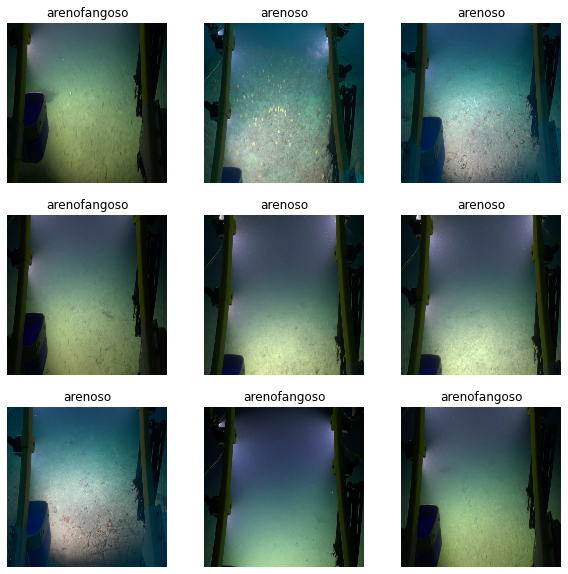

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    #layers.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
,
  ]
)

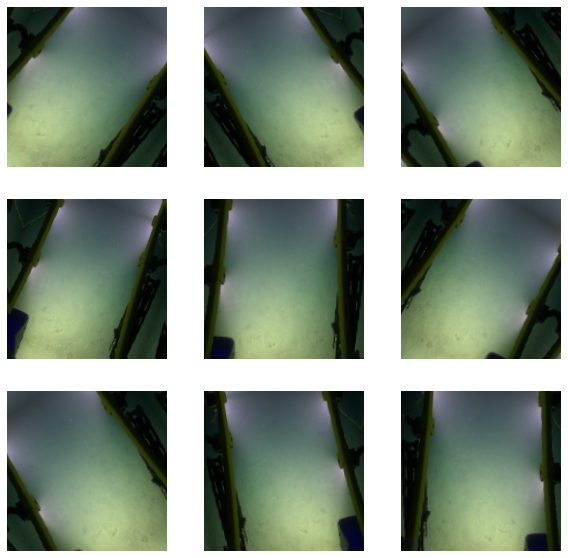

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (img_width, img_width)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(16, 5, 5, 1280)


In [ ]:
base_model.trainable = False


In [ ]:
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(16, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(16, 4)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
len(model.trainable_variables)


2

In [ ]:
initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)


Epoch 1/10
143/143 [==============================] - 17s 92ms/step - loss: 1.1630 - accuracy: 0.4842 - val_loss: 0.9422 - val_accuracy: 0.6235
Epoch 2/10
143/143 [==============================] - 13s 85ms/step - loss: 0.8302 - accuracy: 0.6471 - val_loss: 0.8375 - val_accuracy: 0.6585
Epoch 3/10
143/143 [==============================] - 12s 84ms/step - loss: 0.6761 - accuracy: 0.7325 - val_loss: 0.7710 - val_accuracy: 0.6813
Epoch 4/10
143/143 [==============================] - 13s 87ms/step - loss: 0.5890 - accuracy: 0.7680 - val_loss: 0.7431 - val_accuracy: 0.6883
Epoch 5/10
143/143 [==============================] - 13s 86ms/step - loss: 0.5447 - accuracy: 0.7859 - val_loss: 0.7185 - val_accuracy: 0.6708
Epoch 6/10
143/143 [==============================] - 13s 85ms/step - loss: 0.4916 - accuracy: 0.8117 - val_loss: 0.7064 - val_accuracy: 0.6673
Epoch 7/10
143/143 [==============================] - 13s 85ms/step - loss: 0.4683 - accuracy: 0.8130 - val_loss: 0.7034 - val_accuracy:

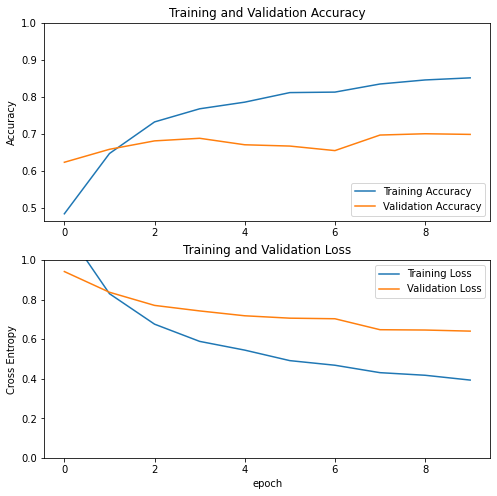

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
base_model.trainable = True


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [ ]:
len(model.trainable_variables)


56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)


Epoch 10/20
143/143 [==============================] - 20s 99ms/step - loss: 0.3412 - accuracy: 0.8673 - val_loss: 0.3858 - val_accuracy: 0.8459
Epoch 11/20
143/143 [==============================] - 14s 94ms/step - loss: 0.2631 - accuracy: 0.8980 - val_loss: 0.3403 - val_accuracy: 0.8914
Epoch 12/20
143/143 [==============================] - 14s 92ms/step - loss: 0.2007 - accuracy: 0.9225 - val_loss: 0.1833 - val_accuracy: 0.9422
Epoch 13/20
143/143 [==============================] - 14s 93ms/step - loss: 0.1874 - accuracy: 0.9229 - val_loss: 0.1809 - val_accuracy: 0.9562
Epoch 14/20
143/143 [==============================] - 14s 95ms/step - loss: 0.1532 - accuracy: 0.9396 - val_loss: 0.4059 - val_accuracy: 0.8424
Epoch 15/20
143/143 [==============================] - 14s 94ms/step - loss: 0.1600 - accuracy: 0.9343 - val_loss: 0.2576 - val_accuracy: 0.8967
Epoch 16/20
143/143 [==============================] - 14s 92ms/step - loss: 0.1596 - accuracy: 0.9330 - val_loss: 0.1597 - val_ac

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


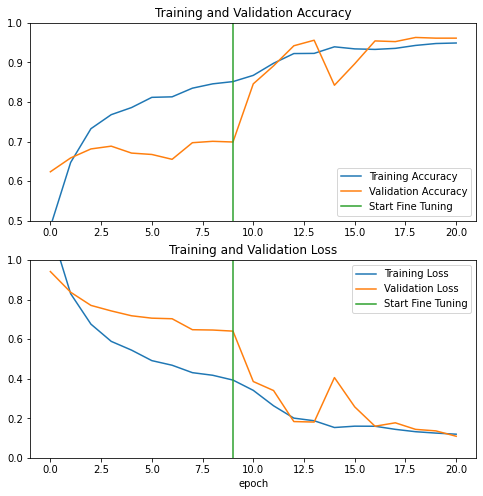

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
